## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.models.deeplab import DeepLab, deeplab_style_vgg

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplab")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

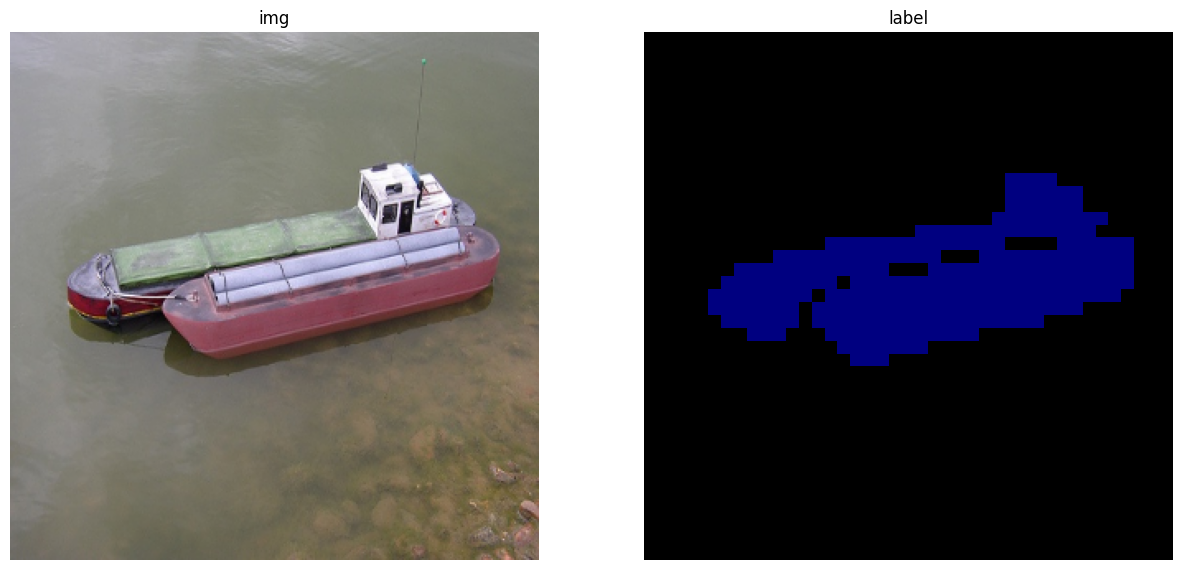

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [11]:
backbone = deeplab_style_vgg("vgg16", trainable=True, large_fov=True, pool_5_type="avg")
model = DeepLab(backbone, NUM_CLASS + 1, large_fov=True).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DeepLab                                       --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       1,792
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       36,928
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       73,856
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       147,584
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      295,168
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      590,080
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      590,080
│    │    └─ReLU: 3-16           

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 182/182 [05:06<00:00,  1.69s/it]


------------------------------------
Epoch 1
------------------------------------
total: 6.0632e-02 (0.00%)


100%|██████████| 182/182 [01:13<00:00,  2.48it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.5077e-02 (-42.00%)


100%|██████████| 182/182 [01:18<00:00,  2.32it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.6623e-02 (-24.00%)


100%|██████████| 182/182 [01:19<00:00,  2.28it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.1061e-02 (-21.00%)


100%|██████████| 182/182 [01:22<00:00,  2.20it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.7578e-02 (-17.00%)


100%|██████████| 182/182 [01:25<00:00,  2.12it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.5865e-02 (-10.00%)


100%|██████████| 182/182 [01:30<00:00,  2.02it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.3375e-02 (-16.00%)


100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.2039e-02 (-10.00%)


100%|██████████| 182/182 [01:32<00:00,  1.96it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.0499e-02 (-13.00%)


100%|██████████| 182/182 [01:22<00:00,  2.21it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.0289e-02 (-2.00%)


100%|██████████| 182/182 [01:24<00:00,  2.16it/s]


------------------------------------
Epoch 11
------------------------------------
total: 8.4253e-03 (-18.00%)


100%|██████████| 182/182 [01:30<00:00,  2.02it/s]


------------------------------------
Epoch 12
------------------------------------
total: 7.6463e-03 (-9.00%)


100%|██████████| 182/182 [01:19<00:00,  2.29it/s]


------------------------------------
Epoch 13
------------------------------------
total: 7.4529e-03 (-3.00%)


100%|██████████| 182/182 [01:25<00:00,  2.13it/s]


------------------------------------
Epoch 14
------------------------------------
total: 6.8855e-03 (-8.00%)


100%|██████████| 182/182 [01:24<00:00,  2.15it/s]


------------------------------------
Epoch 15
------------------------------------
total: 6.3413e-03 (-8.00%)


100%|██████████| 182/182 [01:22<00:00,  2.21it/s]


------------------------------------
Epoch 16
------------------------------------
total: 5.8526e-03 (-8.00%)


100%|██████████| 182/182 [01:11<00:00,  2.53it/s]


------------------------------------
Epoch 17
------------------------------------
total: 9.6428e-03 (65.00%)


100%|██████████| 182/182 [01:10<00:00,  2.59it/s]


------------------------------------
Epoch 18
------------------------------------
total: 1.2952e-02 (34.00%)


100%|██████████| 182/182 [01:15<00:00,  2.40it/s]


------------------------------------
Epoch 19
------------------------------------
total: 7.0005e-03 (-46.00%)


100%|██████████| 182/182 [01:56<00:00,  1.57it/s]


------------------------------------
Epoch 20
------------------------------------
total: 5.5439e-03 (-21.00%)


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


------------------------------------
Epoch 21
------------------------------------
total: 5.0416e-03 (-9.00%)


100%|██████████| 182/182 [02:06<00:00,  1.43it/s]


------------------------------------
Epoch 22
------------------------------------
total: 4.7906e-03 (-5.00%)


100%|██████████| 182/182 [02:04<00:00,  1.46it/s]


------------------------------------
Epoch 23
------------------------------------
total: 4.5731e-03 (-5.00%)


100%|██████████| 182/182 [01:36<00:00,  1.88it/s]


------------------------------------
Epoch 24
------------------------------------
total: 4.3925e-03 (-4.00%)


100%|██████████| 182/182 [01:49<00:00,  1.65it/s]


------------------------------------
Epoch 25
------------------------------------
total: 4.3170e-03 (-2.00%)


100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


------------------------------------
Epoch 26
------------------------------------
total: 4.1825e-03 (-3.00%)


100%|██████████| 182/182 [01:57<00:00,  1.54it/s]


------------------------------------
Epoch 27
------------------------------------
total: 4.2054e-03 (1.00%)


100%|██████████| 182/182 [01:31<00:00,  1.99it/s]


------------------------------------
Epoch 28
------------------------------------
total: 4.1421e-03 (-2.00%)


100%|██████████| 182/182 [01:39<00:00,  1.83it/s]


------------------------------------
Epoch 29
------------------------------------
total: 4.0784e-03 (-2.00%)


100%|██████████| 182/182 [01:36<00:00,  1.88it/s]

------------------------------------
Epoch 30
------------------------------------
total: 4.0663e-03 (0.00%)


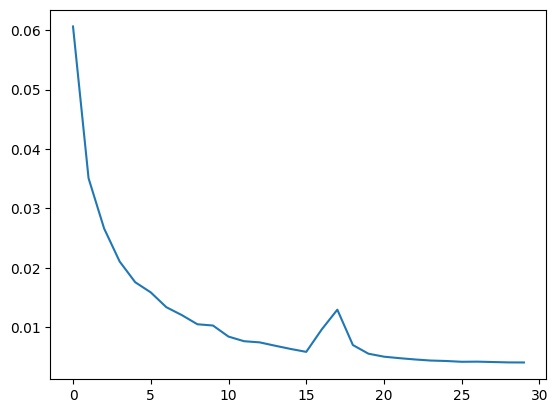

In [18]:
plt.plot(training_loss)

In [24]:
model_path = artifacts_path.joinpath('deeplab.pth')

In [25]:
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

'82.85MiB'

In [14]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [19]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [20]:
evaluator = ClassificationEvaluator(NUM_CLASS + 1, DEVICE)

In [21]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:53<00:00,  1.48it/s]


In [22]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.75 
bicycle        : 0.35 
bird           : 0.75 
boat           : 0.66 
bottle         : 0.6  
bus            : 0.72 
car            : 0.76 
cat            : 0.73 
chair          : 0.38 
cow            : 0.69 
diningtable    : 0.67 
dog            : 0.61 
horse          : 0.64 
motorbike      : 0.73 
person         : 0.72 
pottedplant    : 0.49 
sheep          : 0.73 
sofa           : 0.51 
train          : 0.74 
tvmonitor      : 0.63 
----------------------
total          : 0.64 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

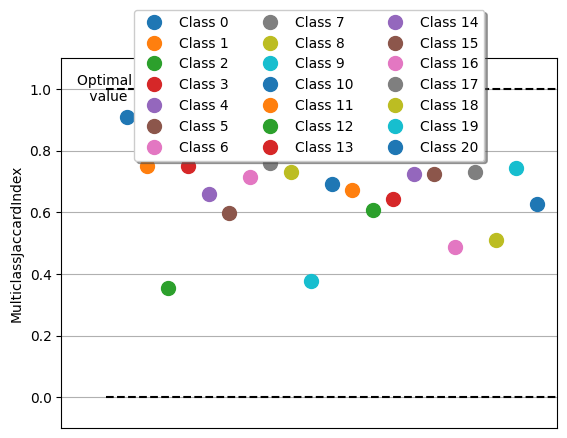

In [23]:
metric.plot()

In [28]:
from torchlake.semantic_segmentation.models.densecrf import DenseCRF

In [29]:
dense_crf = DenseCRF(
    NUM_CLASS + 1,
    appearance_weight=4,
    smoothness_weight=3,
    proximity_std=120,
    color_std=3,
    smoothness_std=3,
    iters=10,
    potts_model=True,
).to(DEVICE)

In [33]:
from typing import Iterable, Any
from torch import nn

class DenseCRFEvaluator(ClassificationEvaluator):
    def _predict_with_tensor(
        self,
        row: tuple[Iterable],
        model: nn.Module,
        *args,
        **kwargs,
    ) -> torch.Tensor | Any:
        x, _ = row
        x: torch.Tensor = x.to(self.device)
        output = model(x, *args, **kwargs)
        # for output that has feature in last
        if self.feature_last:
            output = output.permute(0, -1, *range(1, len(output.shape) - 1))
        return output, x
    
    def _decode_output(
        self,
        output: torch.Tensor | tuple[torch.Tensor],
        *args,
        **kwargs,
    ) -> torch.Tensor | tuple[torch.Tensor]:
        output, x = output
        
        for i in range(len(x)):
            output[i] = dense_crf(x[i], output[i])

        output = output.argmax(dim=self.feature_dim)
        
        return output

In [34]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [35]:
evaluator = DenseCRFEvaluator(NUM_CLASS + 1, DEVICE)

In [36]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [44:23<00:00, 33.72s/it]


In [37]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.4  
bicycle        : 0.09 
bird           : 0.74 
boat           : 0.26 
bottle         : 0.4  
bus            : 0.69 
car            : 0.69 
cat            : 0.73 
chair          : 0.19 
cow            : 0.61 
diningtable    : 0.61 
dog            : 0.5  
horse          : 0.49 
motorbike      : 0.55 
person         : 0.57 
pottedplant    : 0.19 
sheep          : 0.63 
sofa           : 0.33 
train          : 0.65 
tvmonitor      : 0.32 
----------------------
total          : 0.48 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

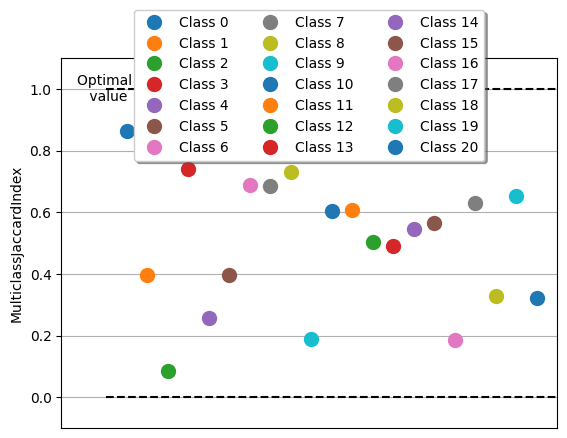

In [38]:
metric.plot()

### for image in dataset

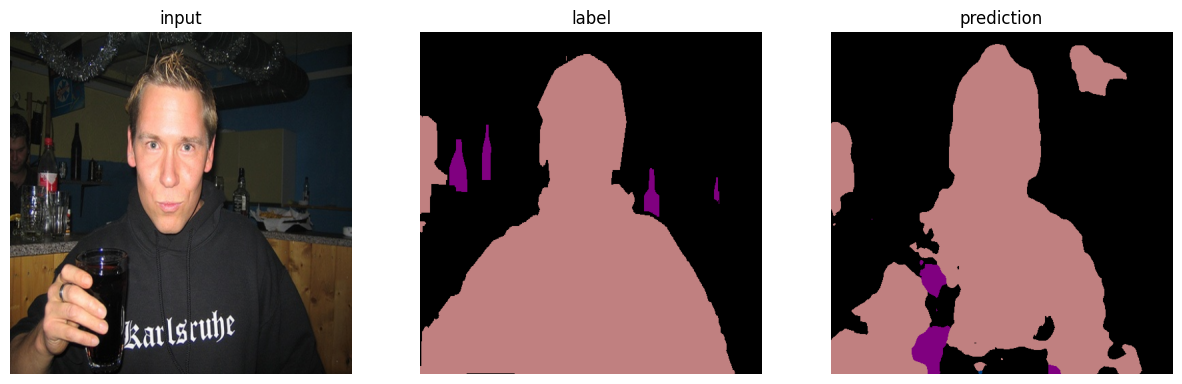

In [16]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

In [ ]:
# import cv2
# import numpy as np

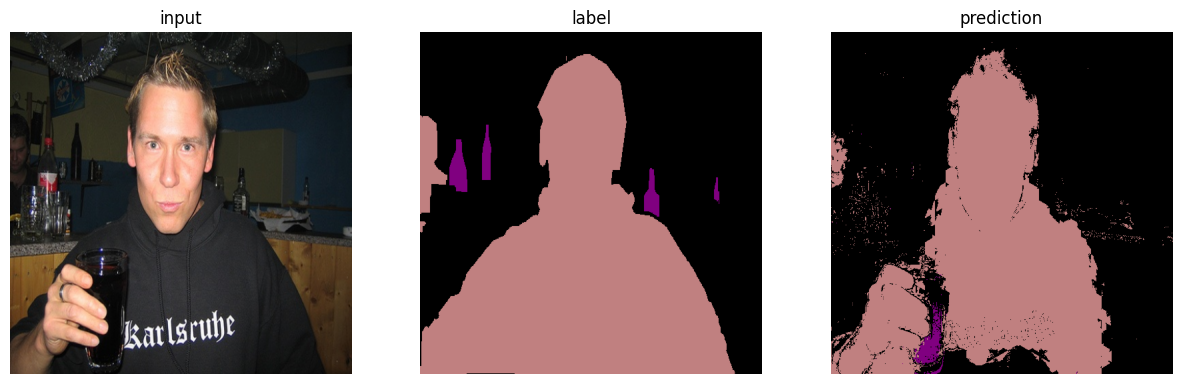

In [55]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]
    target_img = target_img.to(DEVICE)

    # C, H, W
    output = model(target_img.unsqueeze(0))[0]
    output = dense_crf((target_img * 255).long(), output)
    # H, W
    output = output.argmax(dim=0).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
        # decode_segmap(cv2.GaussianBlur(output.unsqueeze(-1).numpy().astype(np.uint8), (7, 7), 0.5), LABEL_COLORS),
        # decode_segmap(cv2.medianBlur(output.unsqueeze(-1).numpy().astype(np.uint8), 3), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

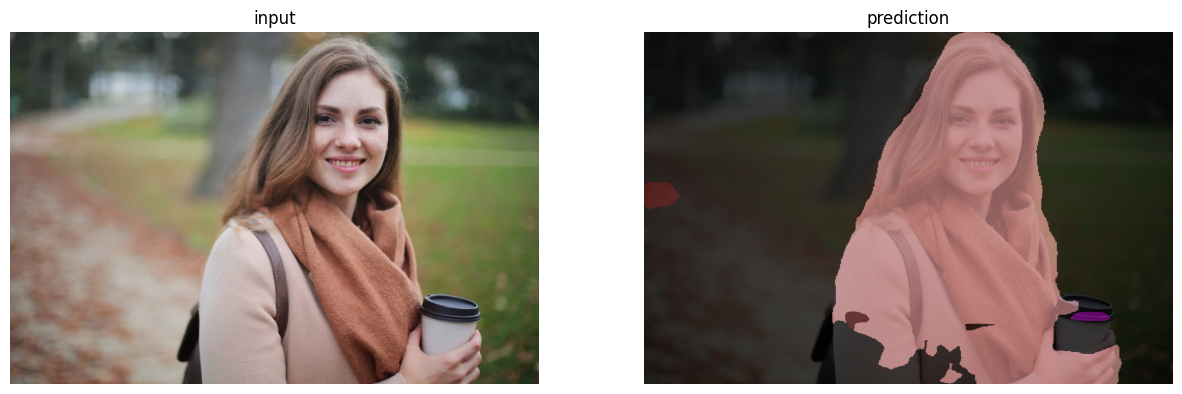

In [ ]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )

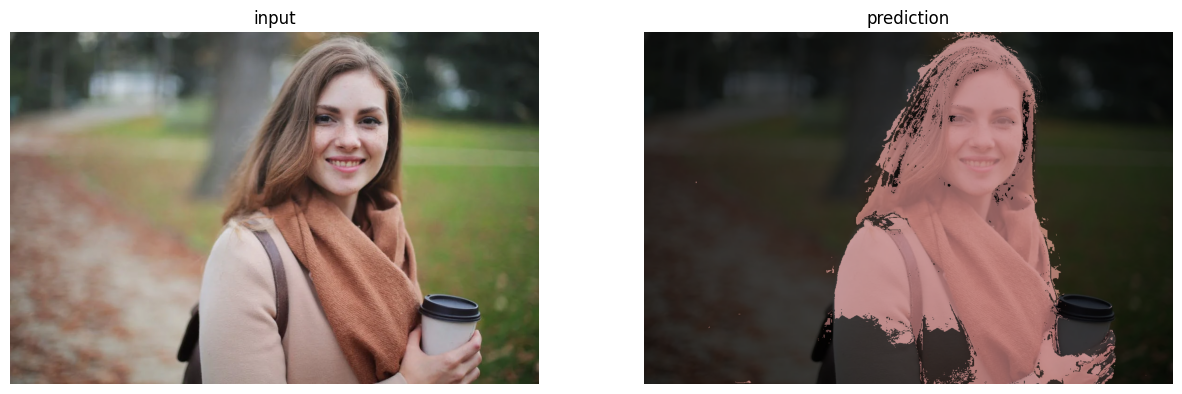

In [ ]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    # C, test_H, test_W
    test_img = test_transform(image=target_img)["image"]
    # 1, C, test_H, test_W
    test_img = test_img.unsqueeze(0).to(DEVICE)
    # 1, C, test_H, test_W => 1, #class, test_H, test_W
    output = model(test_img)
    # 1, #class, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # #class, H, W
    output = dense_crf(torch.from_numpy(target_img).permute(2, 0, 1).to(DEVICE), output[0])
    # test_H, test_W
    output = output.argmax(dim=0)
    # H, W
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )